In [4]:
# Image Caption Model
# Made By: Lawnguy

# Created: 5/10/25
# Last Modified:

# Preprocess The Data

# Go through Artists Profile Picture Folders And Move Them Into Training Data

In [9]:
import os
import shutil

cwd_path = os.getcwd()
parent = os.path.dirname(cwd_path)
output_path = os.path.join(parent, 'Input', 'Data', 'Training Data')

#NOTE* PUT FULL PATH BELOW!!!!!

data_dir= ""

for folder in os.listdir(data_dir):
    print(folder)
    for image in folder:
        try:
            shutil.move(data_dir, output_path)
            print(f"{image} has been moved to {output_path}")
        except FileNotFoundError:
            print(f"File {image} not found.")
        except Exception as e:
            print(f"an error has occurred: {e}")


<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Tyler\AppData\Local\Temp\ipykernel_41600\113782268.py:7: SyntaxWarning: invalid escape sequence '\T'
  data_dir= "C:/Users\Tyler\Downloads\Map Artists of 2b2t/avatars"


1001228521059930133
1 has been moved to C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data
an error has occurred: Destination path 'C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data\avatars' already exists
an error has occurred: Destination path 'C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data\avatars' already exists
an error has occurred: Destination path 'C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data\avatars' already exists
an error has occurred: Destination path 'C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data\avatars' already exists
an error has occurred: Destination path 'C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data\avatars' already exists
an error has occurred: Destination path 'C:\Users\Tyler\PycharmProjects\Image Caption Model\Input\Data\Training Data\avatars' already exists
an error has occurred: Destination pat

# Go Through The Folders and Move The Images Into Training Data And Remove Old Folders

In [21]:
cwd_path = os.getcwd()
parent = os.path.dirname(cwd_path)
data_dir = os.path.join(parent, 'Input', 'Data', 'Training Data', 'avatars')
output_path = os.path.join(parent, 'Input', 'Data', 'Training Data')

os.makedirs(output_path, exist_ok=True)

for folder in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, folder)):
        dst_name = f"{folder}_{image}"
        dst = os.path.join(output_path, dst_name)
        try:
            shutil.move(os.path.join(data_dir, folder, image), dst)
        except FileNotFoundError:
            print(f"File {image} not found.")
        except Exception as e:
            print(f"an error has occurred: {e}")
try:
    shutil.rmtree(data_dir)
    os.rmdir(data_dir)
    print("Removed Folder")
except FileNotFoundError:
    print(f"Folder {data_dir} not found.")
except Exception as e:
    print(f"an error has occurred: {e}")


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\Tyler\\PycharmProjects\\Image Caption Model\\Input\\Data\\Training Data\\avatars'

### Go Through Each Image, Resize, Pixelate

C:\Users\Tyler\AppData\Local\Temp\ipykernel_41600\315533369.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


(256, 256, 3)
Image Before Processing


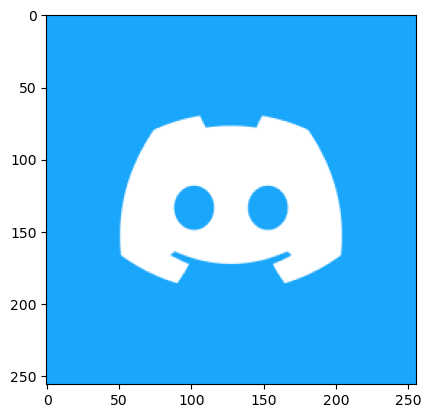

(16, 16, 3)
Image After Processing


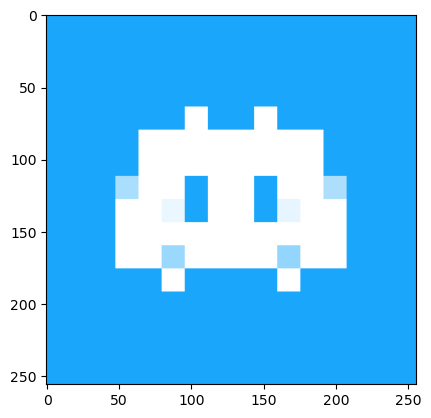

(256, 256, 3)


In [22]:
import imghdr
#Note* If image cant be loaded it will be discarded and logged
import os
from datetime import datetime

import cv2
from matplotlib import pyplot as plt


def log(image_file_name, what_went_wrong):
    """
    The log function creates a log of what went wrong and what
    :param image_file_name: the name of the image getting removed
    :param what_went_wrong: the problem what went wrong
    :return: NONE
    """
    cwd_path = os.getcwd()
    parent = os.path.dirname(cwd_path)
    data_dir = os.path.join(parent, 'Logs')
    time = datetime.now().isoformat()

    try:
        with open(data_dir + '/' + 'log.txt', 'a') as log_file:
            log_file.write(
                str(time) + ": " + str(image_file_name) + ": Was Removed, Reason: " + str(what_went_wrong) + "\n")
            log_file.close()
    except Exception as e:
        print("Somthing Went Wrong In The Logs", e)


def save_pixeled_image_in_file(pixeled_image, image_file_name):
    """
    saves the pixeled image into the directory so it does not overwrite the file
    :param pixeled_image: the pixled image being inputed
    :param image_file_name: the name of the image
    :return: none
    """
    cwd_path = os.getcwd()
    parent = os.path.dirname(cwd_path)
    data_dir = os.path.join(parent, 'Input', 'Data', 'Pixeled Images')

    try:
        if not image_file_name.lower().endswith(('png', 'jpg', 'jpeg')):
            image_file_name = image_file_name + '.png'

        out_put_path = data_dir + '/' + "Pixeled " + image_file_name
        cv2.imwrite(out_put_path, pixeled_image)
    except Exception as e:
        print("Somthing Went Wrong In Saving Pixled Image", e)
        log(image_file_name, "Could Not Save Pixeld Image")

cwd_path = os.getcwd()
parent = os.path.dirname(cwd_path)

data_dir = os.path.join(parent, 'Input', "Data", 'Training Data')
images_extentions = ['png', 'jpg', 'jpeg']

for image in os.listdir(data_dir):
    image_being_processed = os.path.join(data_dir, image)
    what_image_extension = imghdr.what(image_being_processed)

    img = cv2.imread(str(image_being_processed), cv2.IMREAD_COLOR)

    if img is None or what_image_extension not in images_extentions:
        log(image_being_processed, what_image_extension)
        os.remove(image_being_processed)

    else:
        try:
            resized_image = cv2.resize(img, (256, 256))
            small_image = cv2.resize(resized_image, (16, 16), interpolation=cv2.INTER_LINEAR)
            pixeled_image = cv2.resize(small_image, (256, 256), interpolation=cv2.INTER_NEAREST)
            save_pixeled_image_in_file(pixeled_image, image)

        except Exception as e:
            print("Something went wrong resizing: ", e)
            log(image_being_processed, "Couldn't Resize")

# image before pixelization with last image
# NOTE: Image Colors Below are not what they actually are
print(resized_image.shape)
print("Image Before Processing")
plt.imshow(resized_image)
plt.show()

# image after pixelization with last image
# NOTE: Image Colors Below are not what they actually are
print(small_image.shape)
print("Image After Processing")
plt.imshow(pixeled_image)
plt.show()
print(pixeled_image.shape)

### Find avg RGB value of the Total Image
All Images are split into segments with each segment getting a rgb value

In [23]:
import os
import cv2
import statistics
from treelib import Node, Tree
import math

from skimage.color import rgb2lab, deltaE_cie76
import numpy as np

def get_lab_distance(color1_rgb, color2_rgb):
    lab1 = rgb2lab(np.uint8([[color1_rgb]]))[0][0]
    lab2 = rgb2lab(np.uint8([[color2_rgb]]))[0][0]
    return deltaE_cie76(lab1, lab2)



def get_distance_bucket(distance, step=50):
    """
    gets the bucket of the distance ex. 0-49 ...

    :param distance: the Euclidean of the rgb value m
    :param step: 50 (range of the bucket)
    :return: string of start - end
    """
    start = int(distance // step) * step
    end = start + step -1
    return f"{start}-{end}"

all_rgb_data = []
cwd_path = os.getcwd()
parent = os.path.dirname(cwd_path)

data_dir = os.path.join(parent, 'Input', "Data", 'Pixeled Images')

for image in os.listdir(data_dir):
    red_value = []
    blue_value = []
    green_value = []

    image_being_processed = os.path.join(data_dir, image)
    img = cv2.imread(str(image_being_processed), cv2.IMREAD_COLOR)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            r, g, b = img[x,y]
            red_value.append(r)
            blue_value.append(b)
            green_value.append(g)
        #print(f"Imgae RGB Values for {image} pixels[{x},{y}]: Blue Value: {b} Red Value: {r} Green Value: {g}")
    median_r = statistics.median(red_value)
    median_b = statistics.median(blue_value)
    median_g = statistics.median(green_value)

    #print(f"\nMedian Red Value: {median_r}, Median Blue Value: {median_b}, Median Green: {median_g}\n")

    median_RGB_Tuple = (median_r, median_g, median_b)
    distance = get_lab_distance(median_RGB_Tuple, (255, 255, 255))

    lab_value = rgb2lab(np.uint8([[median_RGB_Tuple]]))[0][0]
    rgb_dic = {"Name": image, "RGB": median_RGB_Tuple, "Distance": distance, "Lab": lab_value}
    all_rgb_data.append(rgb_dic)
all_rgb_data.sort(key=lambda rgb_dic: rgb_dic["Distance"])

tree = Tree()
tree.create_node("Root", "root")

for idx, rgb_node, in enumerate(all_rgb_data):
    distance = rgb_node["Distance"]
    bucket_label = get_distance_bucket(distance)
    bucket_id = f"bucket_{bucket_label.replace('-', '_')}"

    if not tree.contains(bucket_id):
        tree.create_node(
            tag=f"Distance {bucket_label}",
            identifier=bucket_id,
            parent='root'
        )
    tag = f'{rgb_node["Name"]} | Dist: {distance:.2f}'
    identifier = f'img_{idx}'

    tree.create_node(
        tag=tag,
        identifier=identifier,
        parent=bucket_id,
        data=rgb_node)
tree.show()

C:\Users\Tyler\anaconda3\Lib\statistics.py:622: RuntimeWarning: overflow encountered in scalar add
  return (data[i - 1] + data[i]) / 2


Root
├── Distance 0-49
│   ├── Pixeled 1110d2b4016641c6611225b4e46fa107.jpeg | Dist: 46.81
│   ├── Pixeled 11aefa70a2407ce4c7854c7269dd3a23.png | Dist: 47.20
│   ├── Pixeled 3eabdd8f405a3565459574f64fde1409.png | Dist: 47.20
│   ├── Pixeled 3fae82f73c6392fffd87912f00b11097.png | Dist: 48.26
│   ├── Pixeled 425677568566624271_05f6ce4209b459e6e7d65b674eae0a5a.png | Dist: 46.81
│   ├── Pixeled 439687256907710464_6121d4b8b468adacc1cc421ce7e8c200.jpeg | Dist: 48.54
│   ├── Pixeled 449882490455326721_271e36a0d76523bbfa627edda698faed.png | Dist: 46.81
│   ├── Pixeled 572909880441307156_6ba83c3811ca5f1d2153675564614553.jpeg | Dist: 48.78
│   ├── Pixeled 637454956378456085_4a9183ca3584bf942b902f62876bd035.png | Dist: 46.81
│   ├── Pixeled 652473002662821908_a6a8f910eb650b7f6a8624d875cdcc0a.png | Dist: 46.81
│   ├── Pixeled 694493966183170149_e4f5d0bf90564d2c79b0705db1141217.png | Dist: 46.81
│   ├── Pixeled 732d0eb1e8ae352f6532565151a41c41.jpeg | Dist: 48.78
│   ├── Pixeled 74e0db6e7af251376a30

### Find Image That Most Perfectly Matches The Training Data

In [24]:
import numpy as np
from skimage.color import rgb2lab
from skimage.color.delta_e import deltaE_ciede2000
from skimage.exposure import match_histograms
import os

cwd_path = os.getcwd()
parent = os.path.dirname(cwd_path)
data_dir = os.path.join(parent, 'Input', "Data", 'Master Image')

image_dir = os.path.join(parent, 'Input', "Data", 'Training Data')
output_dir = os.path.join(parent, 'Output')

os.makedirs(output_dir, exist_ok=True)


all_nodes = [n for n in tree.all_nodes() if n.identifier.startswith("img_")]
last_used_filename = None

for image in os.listdir(data_dir):
    image_being_processed = os.path.join(data_dir, image)
    img = cv2.imread(str(image_being_processed), cv2.IMREAD_COLOR)

    canvas = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for x in range(0, img.shape[0], 10):
        for y in range(0, img.shape[1], 10):
            block = img[x:x+10, y:y+10]
            if block.shape[0] < 10 or block.shape[1] < 10:
                continue

            reshaped_block = block.reshape(-1, 3)
            median_rgb = np.median(reshaped_block, axis=0).astype(np.uint8)
            lab1 = rgb2lab(np.uint8([[median_rgb]]))[0][0]

            valid_nodes = [n for n in all_nodes if n.data["Name"] != last_used_filename]
            if not valid_nodes:
                valid_nodes = all_nodes

            closest_node = min(
                valid_nodes,
                key=lambda n: deltaE_ciede2000(
                    lab1[np.newaxis, :],
                    np.array([n.data["Lab"]])
                )[0]
            )

            last_used_filename = closest_node.data["Name"]
            filename = last_used_filename.replace("Pixeled ", "")
            full_path = os.path.join(image_dir, filename)

            match_img = cv2.imread(full_path)
            if match_img is None:
                print(f"Warning: Could not load {full_path}")
                continue

            resized_match = cv2.resize(match_img, (10, 10))
            try:
                adjusted_tile = match_histograms(resized_match, block, channel_axis=-1)
                adjusted_tile = np.clip(adjusted_tile, 0, 255).astype(np.uint8)
            except Exception as e:
                print(f"Histogram match failed for {filename}: {e}")
                adjusted_tile = resized_match

            canvas[x:x+10, y:y+10] = adjusted_tile

    output_path = os.path.join(output_dir, f"mosaic_output_{os.path.splitext(image)[0]}.jpg")
    cv2.imwrite(output_path, canvas)
